In [1]:

import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from echospec.utils.parameters import Parameters
from echospec.experiments.spectroscopy_vs_amplitude import AmplitudeSweepSpectroscopy, OptionsSpectroscopy2d
from echospec.utils.units import Units as u

from echospec.simulation.torry import find_fwhm_vec_vs_rabi

1.99999980000002e-05


Amplitude sweep:   0%|          | 0/101 [00:00<?, ?Ω/s]

Amplitude sweep:   0%|          | 0/101 [00:00<?, ?Ω/s]

Amplitude sweep:   0%|          | 0/101 [00:00<?, ?Ω/s]

Amplitude sweep:   0%|          | 0/101 [00:00<?, ?Ω/s]

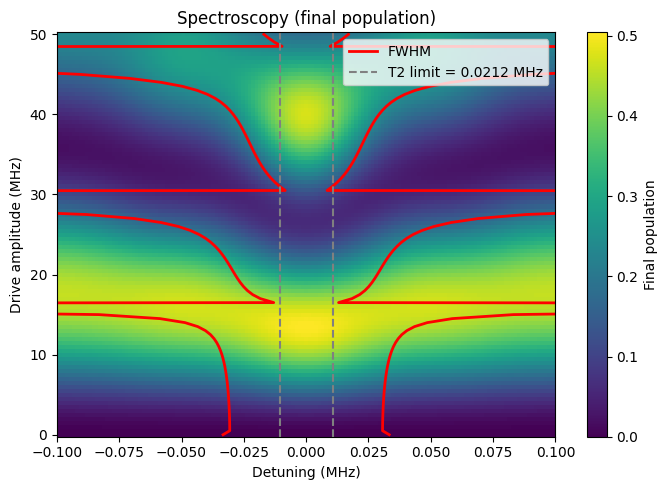

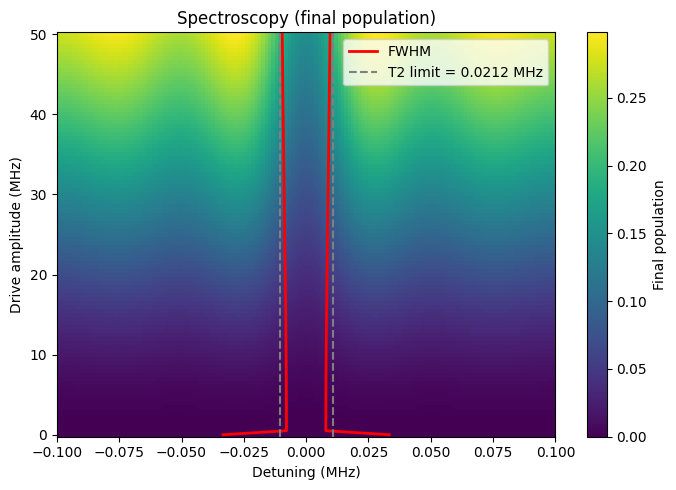

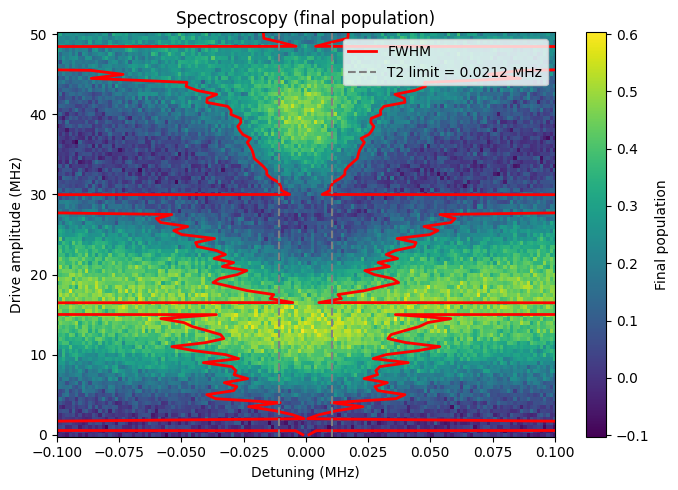

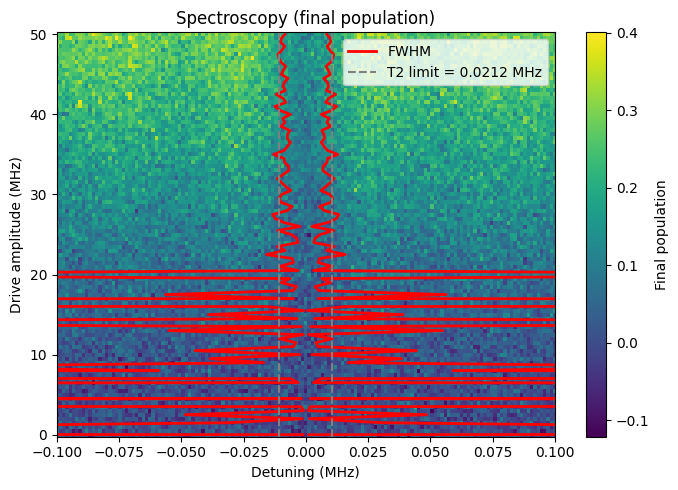

In [2]:
import numpy as np

# ------------------------------------------------------------
# Sweep grids
# ------------------------------------------------------------
detunings = np.linspace(-0.1, 0.1, 151) * 2 * np.pi * u.MHz
amplitudes = np.linspace(0, 50, 101) * 2 * np.pi * u.MHz


# ------------------------------------------------------------
# Helper
# ------------------------------------------------------------
def run_spectroscopy(
    *,
    amplitudes,
    detunings,
    eco_pulse: bool,
    noise: float,
    num_time_points: int = 1000,
):
    options = OptionsSpectroscopy2d(
        plot=True,
        num_time_points=num_time_points,
        noise=noise,
    )

    params = Parameters()
    params.eco_pulse = eco_pulse

    experiment = AmplitudeSweepSpectroscopy(
        amplitudes=amplitudes,
        detunings=detunings,
        params=params,
        options=options,
    )

    return experiment.run()


# ------------------------------------------------------------
# Runs
# ------------------------------------------------------------
results_clean = {
    "no_noise": {
        "normal": run_spectroscopy(
            amplitudes=amplitudes,
            detunings=detunings,
            eco_pulse=False,
            noise=0.0,
        ),
        "echo": run_spectroscopy(
            amplitudes=amplitudes,
            detunings=detunings,
            eco_pulse=True,
            noise=0.0,
        ),
    },
    "with_noise": {
        "normal": run_spectroscopy(
            amplitudes=amplitudes,
            detunings=detunings,
            eco_pulse=False,
            noise=0.08,
        ),
        "echo": run_spectroscopy(
            amplitudes=amplitudes,
            detunings=detunings,
            eco_pulse=True,
            noise=0.08,
        ),
    },
}

/var/folders/5l/mx_yndbx4sq978lx9ht2346r0000gn/T/ipykernel_97563/574831402.py:29: RuntimeWarning: divide by zero encountered in divide
  return fwhm / T2_limit / snr


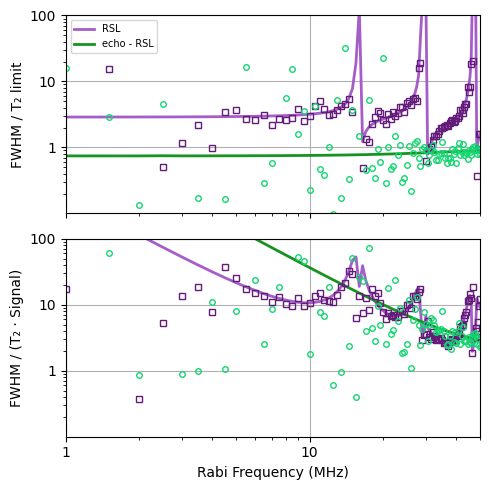

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
params = Parameters()

# ------------------------------------------------------------
# Constants & helpers
# ------------------------------------------------------------
# ------------------------------------------------------------
# Color palette
# ------------------------------------------------------------
COL_NORMAL_DARK = "#631d78"    # data (points)
COL_NORMAL_LIGHT = "#a55dc9"   # simulation (lines)

COL_ECHO_DARK = "#13d671"      # data (points)
COL_ECHO_LIGHT = "#189321"     # simulation (lines)

COL_THEORY = "0.3"            # theory (dark gray)


MHz = 2 * np.pi * u.MHz
T2_limit = params.T2_limit

def to_mhz(x):
    return x / MHz

def fwhm_norm(fwhm):
    return fwhm / T2_limit

def fwhm_over_snr_norm(fwhm, snr):
    return fwhm / T2_limit / snr


# ------------------------------------------------------------
# Theory
# ------------------------------------------------------------
ws, fwhm_th, snr_th = find_fwhm_vec_vs_rabi(
    T1=params.T1,
    T2=params.T2,
)





# ax[0].plot(
#     to_mhz(ws),
#     fwhm_th / T2_limit,
#     color=COL_THEORY,
#     linestyle="-",
#     linewidth=2,
#     # label="const",
# )

# ax[1].plot(
#     to_mhz(ws),
#     fwhm_th / T2_limit / snr_th,
#     color=COL_THEORY,
#     linestyle="-",
#     linewidth=2,
#     # label="const",
# )


# ------------------------------------------------------------
# Simulations
# ------------------------------------------------------------



clean_style= dict(linestyle="-", linewidth = 2,color=COL_NORMAL_LIGHT)
noisy_style = dict(linestyle="", marker="s", markersize=4, color=COL_NORMAL_DARK, fillstyle='none')
clean_style_echo = dict(linestyle="-", linewidth=2, color=COL_ECHO_LIGHT)
noisy_style_echo = dict(linestyle="", marker="o",color=COL_ECHO_DARK,markersize=4,fillstyle='none')

sim_sets = [
    (results_clean["no_noise"]["normal"], clean_style),
    (results_clean["no_noise"]["echo"],   clean_style_echo),
    (results_clean["with_noise"]["normal"], noisy_style),
    (results_clean["with_noise"]["echo"],   noisy_style_echo),
]

for res, style in sim_sets:
    fwhm = res.fwhm_map
    snr = res.snr_map  # dimensionless

    ax[0].plot(
        to_mhz(amplitudes),
        fwhm_norm(fwhm)/2/ np.pi,
        # label=label,
        **style,
    )

    ax[1].plot(
        to_mhz(amplitudes),
        fwhm_over_snr_norm(fwhm, snr)/2/ np.pi,
        # label=label,
        **style,
    )


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
for a in ax:
    a.set_xscale("log")
    a.set_yscale("log")
    a.set_xlim(1, 1e2)
    a.set_xticks([1e-3, 1e-2, 1e-1, 1, 10, 100])
    a.set_xticklabels(["0.001", "0.01", "0.1", "1", "10", "100"])
    a.set_yticks([1, 10, 100, 1000])
    a.set_yticklabels(["1", "10", "100", "1000"])
    a.grid(True)

ax[0].set_ylim(1e-1, 1e3)
ax[0].set_ylabel("FWHM / T₂ limit")
ax[0].set_ylim(0.1, 100)

ax[1].set_ylim(1e0, 1e3)
ax[1].set_xlim(1, 50)
ax[1].set_ylim(0.1, 100)

ax[1].set_ylabel("FWHM / (T₂ · Signal)")
ax[1].set_xlabel("Rabi Frequency (MHz)")

ax[0].legend(['RSL','echo - RSL'],fontsize=7)
# ax[1].legend(fontsize=7)

plt.tight_layout()
plt.savefig("fwhm_vs_rabi.png", dpi=300)
plt.show()